# Calculating the Time to a Population Feature

This is a notebook that will quickly walk through the calculations needed to determine the exposure time to a given stellar population feature, such as the Tip of the Red Giant Branch (TRGB), the Horizontal Branch (HB, or Red Clump), or the Main Sequence Turn-Off (MSTO).

In [1]:
# all we need is numpy, matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# These are just preferences for making plots
# If you are getting errors from matplotlib, feel free to comment this out
plt.rc('font', **{'size': 8, 'sans-serif': ['Helvetica'], 'family': 'sans-serif'})
plt.rc('legend',**{'fontsize':6})                                             
plt.rc("text.latex", preamble=[
    "\\usepackage[T1]{fontenc}\\usepackage{amsmath}"])
plt.rc("text", usetex=True)
plt.rc('ps', usedistiller='xpdf')
plt.rc('savefig', **{'dpi': 300})

Like the other notebooks, we begin by defining a lot of the same variables.

In [4]:
# First setting the range of metallicities and ages that are covered, these are our default values
metlist = np.array([0.5,0.25,0.0,-0.25,-0.5,-0.75,-1.0,-1.25,-1.5,-1.75,-2.0,-2.25,-2.5,-2.75,-3.,-3.25])
agelist = np.array([8.95,9.,9.05,9.1,9.15,9.2,9.25,9.3,9.35,9.4,9.45,9.5,9.55,9.6,9.65,9.7,9.75,9.8,9.85,9.9,9.95,10.,10.05,10.1])
nmet  = len(metlist)
nage  = len(agelist)

# for MIST
nfilt = 7
filter_names = np.array([r"$F062$",r"$F087$",r"$F106$",r"$F129$",r"$F146$",r"$F158$",r"$F184$"])
# filter indexes to be used below
filter_index_dict = {"F062":9,"F087":10,"F106":11,"F129":12,"F146":13,"F158":14,"F184":15}
# 5-sigma point source detection limit for 10^3 sec exposure in each band
ps_detect_5slim = np.array([28.5, 28.2, 28.1, 28.0, 28.4, 28.0, 27.4])
path_to_isos = "../mist_isos"

The absolute magnitudes of each evolutionary stage are calculated in the `feature_absM_calc.ipynb` notebook which can be found in the `calculation_code` directory. We will simply load up the results of those calulations here. Below we load these pre-calculated files for the Main-Sequence Turn-Off (MSTO), the Horizontal Branch (HB), and the Tip of the REd Giant Branch (TRGB).

In [5]:
msto_mags = np.load("data/msto_mags.npy")
hb_mags = np.load("data/hb_mags.npy")
trgb_mags = np.load("data/trgb_mags.npy")

Again, we can make sure that everything is the right shape, as we might expect.

In [6]:
# check that fdet is the correct shape
print("These all should be the same:")
print("(%d, %d, %d)"%(nmet,nage,nfilt))
print(msto_mags.shape)
print(hb_mags.shape)
print(trgb_mags.shape)

These all should be the same:
(16, 24, 7)
(16, 24, 7)
(16, 24, 7)
(16, 24, 7)


We can the plot our results as a function of metallicity for each age.

Text(0.5, 0, '${\\rm [Fe/H]}$')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


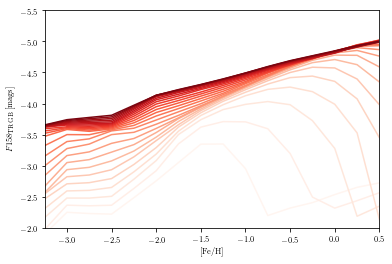

In [7]:
# First choose a filter, let's use F158 which has the index f 5
kfilt = 5

for j in range(nage):
    # make sure we aren't plotting anything without a TRGB
    sids = np.where(trgb_mags[:,j,kfilt] >-900)[0]
    plt.plot(metlist[sids],trgb_mags[sids,j,kfilt],c=plt.cm.Reds((1.*j)/nage))

plt.ylim(-2,-5.5)
plt.xlim(min(metlist),max(metlist))
plt.ylabel(r"$F158_{\rm TRGB} \, [{\rm mags}]$")
plt.xlabel(r"${\rm [Fe/H]}$")

Where we can then see that the brightness of the TRGB is relatively insensitive to age (once the population is old enough) but is a rather strong function of metallicity.

If we then imagine that we are looking at a given galaxy and assume a distance, $D$, to this galaxy, we can translate the absolute magnitude given above in to a minimal exposure time needed to detect the population feature. Lets do this next.

In [8]:
# distance to assumed object, in Mpc
Dobs = 4
# distance modulus to observation
mu = 25 + 5*np.log10(Dobs)
texp = 3.6e3*10**((trgb_mags+mu-ps_detect_5slim[5])/1.25)

Text(0.5, 0, '${\\rm [Fe/H]}$')

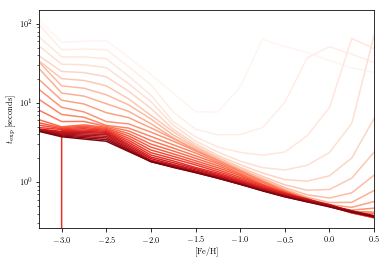

In [9]:
for j in range(nage):
    # make sure we aren't plotting anything without a TRGB
    sids = np.where(trgb_mags[:,j,kfilt] <1e7)[0]
    plt.plot(metlist[sids],texp[sids,j,kfilt],c=plt.cm.Reds((1.*j)/nage))

#plt.ylim(-2,-5.5)
plt.yscale("log")
plt.xlim(min(metlist),max(metlist))
plt.ylabel(r"$t_{\rm exp} \, [{\rm seconds}]$")
plt.xlabel(r"${\rm [Fe/H]}$")

Okay but really we care about whether or not, for a given population, we can detect a certain feature in certain bands. So let's look at several different bands.

Text(0, 0.5, '$t_{\\rm exp}\\, [{\\rm seconds}]$')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


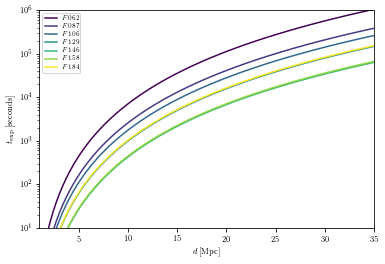

In [10]:
# Then we can pick a given metallicity and age
meti = 10 # [Fe/H] = -2
agej = 21 # age = 10 Gyr

# we'll plot the exposure time for a range of assumed 
drange = np.linspace(1,35,100)
mu = 25 + 5*np.log10(drange)
texp_Rtrgb = 3.6e3*10**((1+trgb_mags[meti,agej,0]+mu-ps_detect_5slim[0])/1.25)
texp_Ztrgb = 3.6e3*10**((1+trgb_mags[meti,agej,1]+mu-ps_detect_5slim[1])/1.25)
texp_Ytrgb = 3.6e3*10**((1+trgb_mags[meti,agej,2]+mu-ps_detect_5slim[2])/1.25)
texp_Jtrgb = 3.6e3*10**((1+trgb_mags[meti,agej,3]+mu-ps_detect_5slim[3])/1.25)
texp_Wtrgb = 3.6e3*10**((1+trgb_mags[meti,agej,4]+mu-ps_detect_5slim[4])/1.25)
texp_Htrgb = 3.6e3*10**((1+trgb_mags[meti,agej,5]+mu-ps_detect_5slim[5])/1.25)
texp_Ftrgb = 3.6e3*10**((1+trgb_mags[meti,agej,6]+mu-ps_detect_5slim[6])/1.25)


plt.plot(drange,texp_Rtrgb,c=plt.cm.viridis(0./(nfilt-1)),label=filter_names[0])
plt.plot(drange,texp_Ztrgb,c=plt.cm.viridis(1./(nfilt-1)),label=filter_names[1])
plt.plot(drange,texp_Ytrgb,c=plt.cm.viridis(2./(nfilt-1)),label=filter_names[2])
plt.plot(drange,texp_Jtrgb,c=plt.cm.viridis(3./(nfilt-1)),label=filter_names[3])
plt.plot(drange,texp_Wtrgb,c=plt.cm.viridis(4./(nfilt-1)),label=filter_names[4])
plt.plot(drange,texp_Htrgb,c=plt.cm.viridis(5./(nfilt-1)),label=filter_names[5])
plt.plot(drange,texp_Ftrgb,c=plt.cm.viridis(6./(nfilt-1)),label=filter_names[6])

plt.legend()
plt.yscale("log")
plt.xlim(1,35)
plt.ylim(1e1,1e6)
plt.xlabel(r"$d\, [{\rm Mpc}]$")
plt.ylabel(r"$t_{\rm exp}\, [{\rm seconds}]$")